<a href="https://colab.research.google.com/github/aekanun2020/2022-PEA-ML-scikitLearn-Spark/blob/main/L_B_sckitlearn_Regression_Pipeline_Estimation_of_Arrival_Delay_noNormalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
     


import numpy as np 
import pandas as pd 
from pandas import plotting

import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')

import plotly as py
import plotly.graph_objs as go
#py.offline.init_notebook_mode(connected = True)

from sklearn.cluster import KMeans
import fastai

import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")
     


In [2]:
! wget https://s3.amazonaws.com/imcbucket/data/flights/2008.csv

--2022-12-05 10:36:10--  https://s3.amazonaws.com/imcbucket/data/flights/2008.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.222.24, 54.231.194.104, 52.217.66.246, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.222.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689413344 (657M) [binary/octet-stream]
Saving to: ‘2008.csv’

2008.csv            100%[===================>] 657.48M  15.5MB/s    in 44s     

2022-12-05 10:36:54 (15.0 MB/s) - ‘2008.csv’ saved [689413344/689413344]



In [3]:
! wc -l 2008.csv

7009729 2008.csv


In [4]:
f = "2008.csv"
num_lines = sum(1 for l in open(f))
size = int(num_lines / 100)
import random
skip_idx = random.sample(range(1, num_lines), num_lines - size)
raw_pd = pd.read_csv(f, skiprows=skip_idx)

In [5]:
#raw_pd = pd.read_csv("2008.csv")

In [6]:
raw_pd.head(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,1142.0,1125,1626.0,1640,WN,1668,...,3.0,5.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,832.0,830,1123.0,1110,WN,3150,...,2.0,13.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,1350.0,1250,1611.0,1520,WN,1035,...,3.0,10.0,0,NaN,0,9.0,0.0,0.0,0.0,42.0
3,2008,1,3,4,824.0,735,1059.0,1020,WN,220,...,4.0,11.0,0,NaN,0,39.0,0.0,0.0,0.0,0.0
4,2008,1,3,4,641.0,640,931.0,1005,WN,2980,...,7.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [7]:
raw_pd.info()

### พบ variables ที่มี Null profile

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70096 entries, 0 to 70095
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               70096 non-null  int64  
 1   Month              70096 non-null  int64  
 2   DayofMonth         70096 non-null  int64  
 3   DayOfWeek          70096 non-null  int64  
 4   DepTime            68724 non-null  float64
 5   CRSDepTime         70096 non-null  int64  
 6   ArrTime            68605 non-null  float64
 7   CRSArrTime         70096 non-null  int64  
 8   UniqueCarrier      70096 non-null  object 
 9   FlightNum          70096 non-null  int64  
 10  TailNum            69231 non-null  object 
 11  ActualElapsedTime  68573 non-null  float64
 12  CRSElapsedTime     70086 non-null  float64
 13  AirTime            68573 non-null  float64
 14  ArrDelay           68573 non-null  float64
 15  DepDelay           68724 non-null  float64
 16  Origin             700

In [8]:
raw_pd.describe().transpose()

### พบ variable ที่เป็นตัวเลขฐานหกสิบ เช่น Deptime (Inconsistency profile)

,count,mean,std,min,25%,50%,75%,max
Year,70096.0,2008.000000,0.000000,2008.0,2008.0,2008.0,2008.0,2008.0
Month,70096.0,6.384929,3.402461,1.0,3.0,6.0,9.0,12.0
DayofMonth,70096.0,15.761213,8.785005,1.0,8.0,16.0,23.0,31.0
DayOfWeek,70096.0,3.916144,1.987180,1.0,2.0,4.0,6.0,7.0
DepTime,68724.0,1333.162025,477.969270,1.0,928.0,1324.0,1728.0,2400.0
CRSDepTime,70096.0,1325.088564,463.993399,1.0,926.0,1316.0,1715.0,2359.0
ArrTime,68605.0,1481.266569,505.011224,1.0,1106.0,1512.0,1910.0,2400.0
CRSArrTime,70096.0,1493.791486,482.903992,1.0,1115.0,1515.0,1907.0,2400.0
FlightNum,70096.0,2233.042813,1964.778283,1.0,625.0,1573.0,3561.0,7829.0
ActualElapsedTime,68573.0,127.134062,69.915045,16.0,76.0,110.0,157.0,675.0


In [9]:
raw_pd.describe().transpose()[['mean','std']].assign(cv=lambda x: (x['std']/x['mean'])*100).sort_values(['cv'],ascending=False)

### พบ variable ที่มี High Dispersion profile (C.V. ตั้งแต่ 100% ขึ้นไป) ซึ่งในที่นี้จะไม่ถูกเลือกนำมาใช้เป็น Feature

,mean,std,cv
SecurityDelay,0.077049,2.158255,2801.143524
Diverted,0.001940,0.044005,2268.080915
Cancelled,0.019787,0.139269,703.836332
WeatherDelay,3.193999,21.238554,664.951895
ArrDelay,8.003062,38.809085,484.927928
DepDelay,9.773078,35.636305,364.637486
CarrierDelay,15.413615,40.662804,263.810955
NASDelay,17.052152,32.849616,192.642051
LateAircraftDelay,20.356680,38.408571,188.677977
FlightNum,2233.042813,1964.778283,87.986593


In [10]:
def t_timeperiod(origin):
    if origin is None:
        period = None
    elif origin > 0 and origin < 600:
        period = '00.01-05.59'
    elif origin >= 600 and origin <=1200:
        period = '06.00-11.59'
    elif origin >= 1200 and origin <= 1800:
        period = '12.00-17.59'
    elif origin >= 1800 and origin <= 2400:
        period = '18.00-24.00'
    else:
        period = 'NA'
    return period

In [11]:
# ทำ Discretization แก้ไข Inconsistency profile

raw_pd['DepTime'] = raw_pd['DepTime'].apply(lambda x:t_timeperiod(x))

In [12]:
features_pd = raw_pd[['UniqueCarrier','Origin','Dest',\
        'DepTime','TaxiOut','TaxiIn','DepDelay',\
        'DayOfWeek','Distance','ArrDelay']]

In [13]:
final_pd = features_pd.dropna()

In [14]:
final_pd.count()

UniqueCarrier    68573
Origin           68573
Dest             68573
DepTime          68573
TaxiOut          68573
TaxiIn           68573
DepDelay         68573
DayOfWeek        68573
Distance         68573
ArrDelay         68573
dtype: int64

In [15]:
features_pd.head(20)

,UniqueCarrier,Origin,Dest,DepTime,TaxiOut,TaxiIn,DepDelay,DayOfWeek,Distance,ArrDelay
0,WN,LAX,MCI,06.00-11.59,5.0,3.0,17.0,4,1363,-14.0
1,WN,MCO,ALB,06.00-11.59,13.0,2.0,2.0,4,1073,13.0
2,WN,MCO,PHL,12.00-17.59,10.0,3.0,60.0,4,861,51.0
3,WN,MDW,SJC,06.00-11.59,11.0,4.0,49.0,4,1838,39.0
4,WN,MHT,MCO,06.00-11.59,10.0,7.0,1.0,4,1142,-34.0
5,WN,MHT,MDW,18.00-24.00,11.0,7.0,14.0,4,838,-1.0
6,WN,MSY,TPA,12.00-17.59,5.0,4.0,86.0,4,487,77.0
7,WN,OAK,PDX,18.00-24.00,15.0,8.0,42.0,4,543,37.0
8,WN,OAK,SLC,18.00-24.00,17.0,6.0,50.0,4,588,49.0
9,WN,ONT,SMF,06.00-11.59,6.0,4.0,-3.0,4,389,-16.0


In [16]:
import pandas as pd
from seaborn import load_dataset
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [17]:
train_df = final_pd.sample(frac=0.8,random_state=123)

In [18]:
test_df = final_pd.drop(train_df.index)

In [19]:
train_df.count()

UniqueCarrier    54858
Origin           54858
Dest             54858
DepTime          54858
TaxiOut          54858
TaxiIn           54858
DepDelay         54858
DayOfWeek        54858
Distance         54858
ArrDelay         54858
dtype: int64

In [20]:
test_df.count()

UniqueCarrier    13715
Origin           13715
Dest             13715
DepTime          13715
TaxiOut          13715
TaxiIn           13715
DepDelay         13715
DayOfWeek        13715
Distance         13715
ArrDelay         13715
dtype: int64

In [21]:
train_labels = train_df.filter(['ArrDelay'])
train_df = train_df.loc[:, train_df.columns != 'ArrDelay']

In [22]:
type(train_labels)

pandas.core.frame.DataFrame

In [23]:
test_labels = test_df.filter(['ArrDelay'])
test_df = test_df.loc[:, test_df.columns != 'ArrDelay']

In [24]:
X_train = train_df
X_test = test_df
y_train = train_labels
y_test = test_labels

In [25]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['UniqueCarrier', 'Origin', 'Dest', 'DepTime']
Numerical columns are: ['TaxiOut', 'TaxiIn', 'DepDelay', 'DayOfWeek', 'Distance']


In [26]:
len(numerical)

5

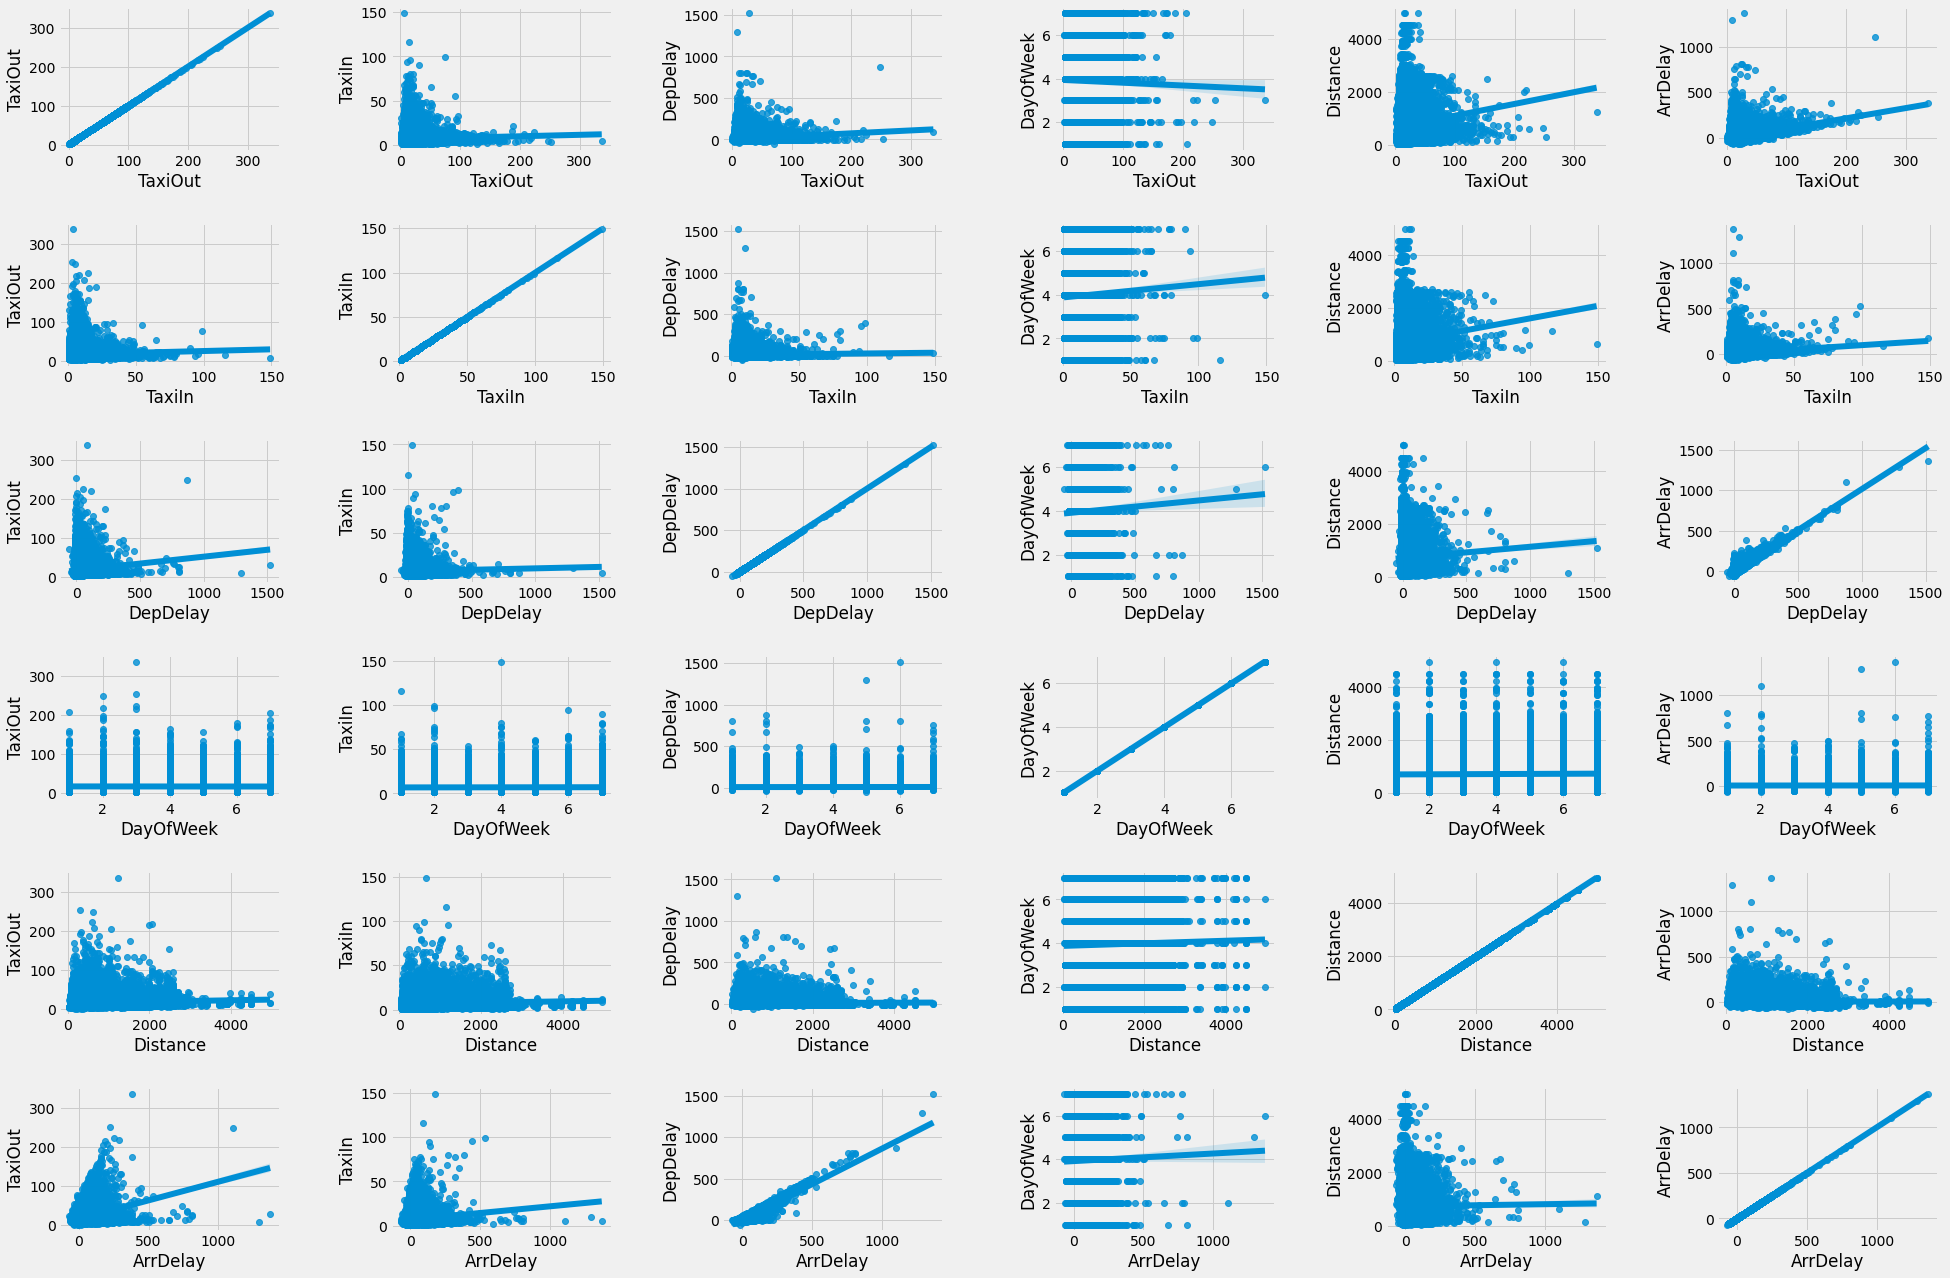

In [27]:




plt.figure(1 , figsize = (30 , 21))
n = 0 
for x in numerical+['ArrDelay']:
    for y in numerical+['ArrDelay']:
        n += 1
        plt.subplot(len(numerical)+1 , len(numerical)+1 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = raw_pd)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
plt.show()
     

     


In [28]:
X_train.drop('Distance',axis=1,inplace=True)

In [29]:
X_train.describe()

,TaxiOut,TaxiIn,DepDelay,DayOfWeek
count,54858.000000,54858.000000,54858.000000,54858.000000
mean,16.454902,6.871887,9.777845,3.921506
std,11.345739,4.946165,35.981367,1.984187
min,1.000000,1.000000,-56.000000,1.000000
25%,10.000000,4.000000,-4.000000,2.000000
50%,14.000000,6.000000,-1.000000,4.000000
75%,19.000000,8.000000,8.000000,6.000000
max,337.000000,149.000000,1521.000000,7.000000


In [30]:
categorical = list(X_train.select_dtypes('object').columns)
print(f"Categorical columns are: {categorical}")

numerical = list(X_train.select_dtypes('number').columns)
print(f"Numerical columns are: {numerical}")

Categorical columns are: ['UniqueCarrier', 'Origin', 'Dest', 'DepTime']
Numerical columns are: ['TaxiOut', 'TaxiIn', 'DepDelay', 'DayOfWeek']


In [31]:
len(numerical)

4

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn import tree
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [33]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# Define categorical pipeline
cat_pipe = Pipeline([('selector', ColumnSelector(categorical)),
                     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Define numerical pipeline
num_pipe = Pipeline([('selector', ColumnSelector(numerical))
                     #('imputer', SimpleImputer(strategy='median')),
                     #('scaler', MinMaxScaler())
                    ])

# Combine categorical and numerical pipeline
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('num', num_pipe)])

# Model Training
pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('model', DecisionTreeRegressor(max_depth=None))])
pipeline_model = pipe.fit(X_train, y_train)

In [34]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

predictions = pipeline_model.predict(X_test)
print("\t RMSE:", mean_squared_error(y_test, predictions, squared=False))
print("\t R2 score:", r2_score(y_test, predictions))

	 RMSE: 13.082628122265431
	 R2 score: 0.87522789129733


In [35]:
X_train.describe()

,TaxiOut,TaxiIn,DepDelay,DayOfWeek
count,54858.000000,54858.000000,54858.000000,54858.000000
mean,16.454902,6.871887,9.777845,3.921506
std,11.345739,4.946165,35.981367,1.984187
min,1.000000,1.000000,-56.000000,1.000000
25%,10.000000,4.000000,-4.000000,2.000000
50%,14.000000,6.000000,-1.000000,4.000000
75%,19.000000,8.000000,8.000000,6.000000
max,337.000000,149.000000,1521.000000,7.000000
